# Main analysis

> Lovisa Franzén, lovisa.franzen@scilifelab.se   
> October, 2019  

Includes data processing, data visualisation, etc.

## Background

Budesonide, sold by AstraZeneca under the brand names Pulmicort and Symbicort, is a glucocorticoid used for long term management of asthma and chronic obstructive pulmonary disease (COPD). The compound can be administered through inhalation or as a pill, among other forms. It was sold for the first time as medication in 1981, and has since held a large part of the consumption market.

In a publication by Barrette et al. (2016)<sup>1</sup>, the authors studied the effect of budesonide treatment in primary human foetal lung explants. They prepared RNA from 3 samples of foetal lung at 23 weeks gestation before (preculture, PC) and after 4 days culture as explants with (Bud) or without (Way) budesonide (30 nM) and performed RNAseq on the 9 samples. The sequencing was performed using Illumina HiSeq 2500, and the processed data is publicly available at Gene Expression Omnibus (accession number <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE83888">GSE83888</a>).   

  
<br>
<span style="font-size:0.8em;">
[1] Anne Marie Barrette, Jessica K. Roberts, Cheryl Chapin, Edmund A. Egan, Mark R. Segal, Juan A. Oses-Prieto, Shreya Chand, Alma L. Burlingame, and Philip L. Ballard, "Antiinflammatory Effects of Budesonide in Human Fetal Lung", *American Journal of Respiratory Cell and Molecular Biology*, 2016, <a href="https://www.atsjournals.org/doi/10.1165/rcmb.2016-0068OC">link to article</a>
</span>

## Set-up

First I set everything up by importing the necessary modules, defining paths, and defining basic functions

In [1]:
import os
import re
import numpy as np
import pandas as pd
import re
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
dir_project = os.path.realpath('..')
dir_data = os.path.join(dir_project, 'data')
dir_res = os.path.join(dir_project, 'results')

In [3]:
def grep(l, p):
    return [i for i in l if p in i]

## Read data

The data files are located in the `data/` folder. To limit the scope of this project, I've decided to exclusively focus on the 'Way' (without treatment) and 'Bud' (with budesonide treatment) groups.

In [4]:
data_files = os.listdir(dir_data)
data_files

['GSM2220787_PC_2.txt',
 'GSM2220786_PC_1.txt',
 'GSM2220784_Bud_2.txt',
 'GSM2220789_Way_1.txt',
 'GSM2220790_Way_2.txt',
 'GSM2220785_Bud_3.txt',
 'GSM2220788_PC_3.txt',
 'GSM2220791_Way_3.txt',
 'GSM2220783_Bud_1.txt']

In [5]:
exp_way_1 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Way')[0]) , sep = '\t')
exp_way_2 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Way')[1]) , sep = '\t')
exp_way_3 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Way')[2]) , sep = '\t')
exp_bud_1 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Bud')[0]) , sep = '\t')
exp_bud_2 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Bud')[1]) , sep = '\t')
exp_bud_3 = pd.read_csv( os.path.join(dir_data, grep(data_files, 'Bud')[2]) , sep = '\t')

In [6]:
exp_way = pd.merge(exp_way_1, exp_way_2, on='Gene').merge(exp_way_3, on='Gene')
exp_bud = pd.merge(exp_bud_1, exp_bud_2, on='Gene').merge(exp_bud_3, on='Gene')

In [7]:
exp_all = pd.merge(exp_way, exp_bud, on='Gene')
exp_all = exp_all.rename(columns={'Gene': 'id', 
                                  'Way_1.cpm': 'way_1',
                                  'Way_2.cpm': 'way_2',
                                  'Way_3.cpm': 'way_3',
                                  'Bud_1.cpm': 'bud_1',
                                  'Bud_2.cpm': 'bud_2',
                                  'Bud_3.cpm': 'bud_3',
                                 })
exp_all

id     way_1    way_2     way_3    bud_2    bud_3    bud_1
0      ENSG00000000003  127.0126  98.2498  111.1196  77.1369  78.8440  79.1299
1      ENSG00000000005    0.0825   0.0462    0.0000   0.0761   0.0000   0.0000
2      ENSG00000000419   59.1461  56.0107   61.0911  62.1508  60.0492  52.3385
3      ENSG00000000457   14.9875  13.2633    9.9430  13.4647  12.4601  10.5766
4      ENSG00000000460   11.1736  11.6458    7.2557   9.3568   7.2247   7.6602
...                ...       ...      ...       ...      ...      ...      ...
83904  ENSG00000269881    0.0000   0.0000    0.0000   0.0000   0.0000   0.0000
83905  ENSG00000269882    0.0000   0.0000    0.0000   0.0000   0.0000   0.0000
83906  ENSG00000269883    0.0000   0.0000    0.0000   0.0000   0.0000   0.0000
83907  ENSG00000269884    0.0000   0.0000    0.0000   0.0000   0.0000   0.0000
83908  ENSG00000269885    0.0000   0.0000    0.0000   0.0000   0.0000   0.0000

[83909 rows x 7 columns]

### Look at data

In [8]:
exp_all.describe()

way_1         way_2         way_3         bud_2         bud_3  \
count  83909.000000  83909.000000  83909.000000  83909.000000  83909.000000   
mean      11.917672     11.917672     11.917674     11.917672     11.917675   
std       85.659276     81.590633     93.709144     93.142985     90.955367   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.144300      0.138600      0.134400      0.152100      0.104700   
max     5790.587500   5375.872000   9180.690300   9657.065500   8089.049500   

              bud_1  
count  83909.000000  
mean      11.917674  
std      110.890260  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.155500  
max    15064.851700

As one can see here, the counts have been normalised through CPM (counts-per-million) conversion and each sample has the same average gene count. I am however unsure if these number are logged (log2)... If that's the case I might need to un-log them before running the DEA.

In [9]:
exp_all.iloc[:,1:].melt()

variable     value
0         way_1  127.0126
1         way_1    0.0825
2         way_1   59.1461
3         way_1   14.9875
4         way_1   11.1736
...         ...       ...
503449    bud_1    0.0000
503450    bud_1    0.0000
503451    bud_1    0.0000
503452    bud_1    0.0000
503453    bud_1    0.0000

[503454 rows x 2 columns]

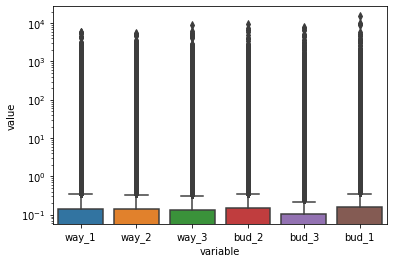

In [10]:
plot_data = exp_all.iloc[:,1:].melt()
g = sns.boxplot(x = "variable", y = "value", data = plot_data)
g.set_yscale("log")
plt.show();

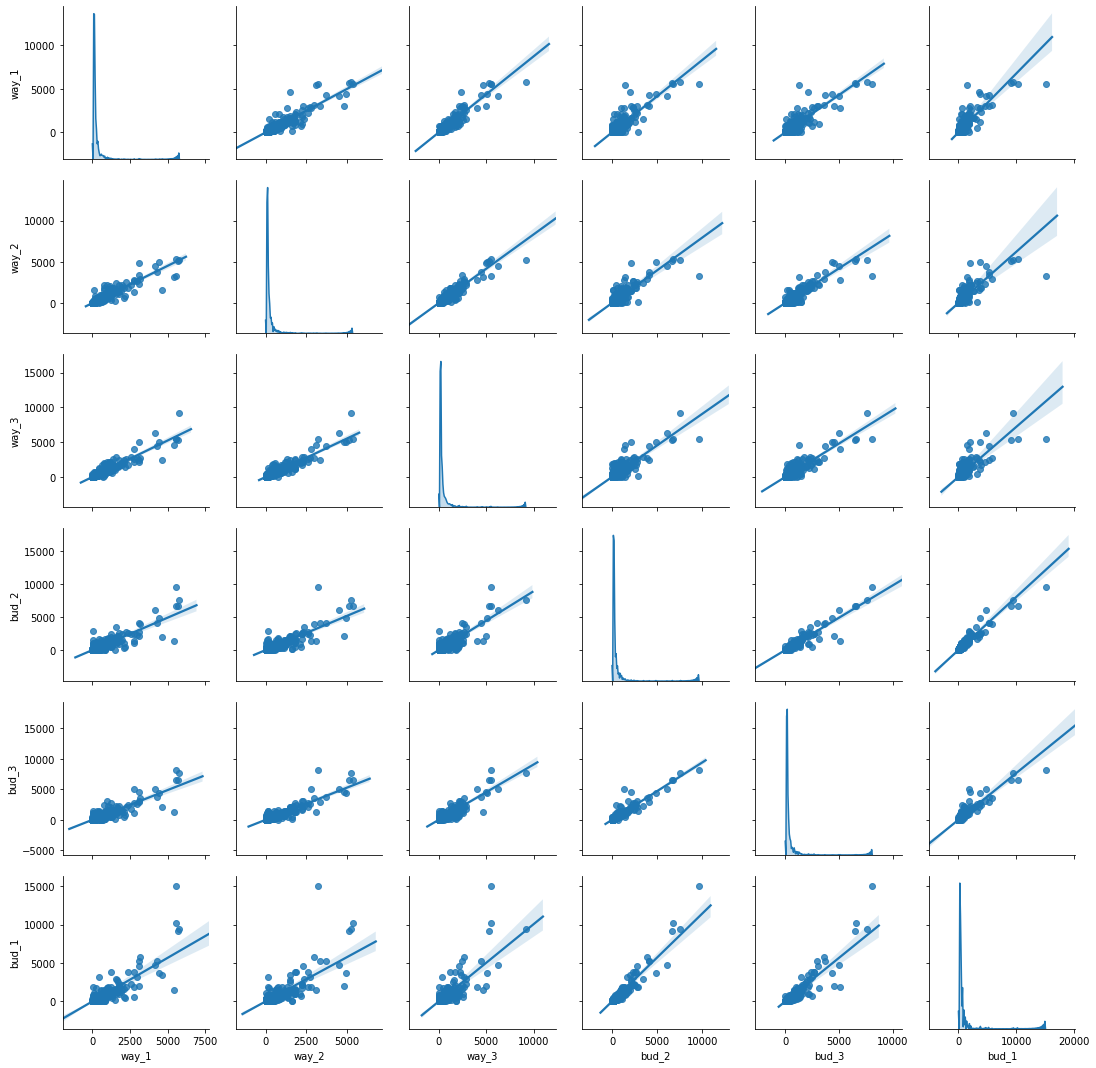

In [11]:
sns.pairplot(exp_all.iloc[:,1:], diag_kind="kde", kind="reg");

The data is generally heavily skewed towards lower counts (positively skewed), as is expected for most RNA seq data. Clearer linear correlations in the expression can moreover be seen within each group, as compared to between groups.

## Differential gene expression analysis

I couldn't find any modules in python that would perform differential expressions analysis (DEA). Among the ones I found, was to port the popular DESeq2 R algorithm using the rpy2 module, however I had issues to get it to work since it's reliant on your R installation.


Instead I built upon the code we worked with during the course.

Define function for doing differential gene expression analysis.
Fold change: The log2 fold-change is log2(mean(post_group)/mean(pre_group))

In [13]:
def dea(expr_df, n_replicates = 3, id_col = "id"):
    """
    :param expr_df:
    :param n_samples:
    :param id_col:
    """
    gene_ids = list(expr_df[id_col])
    expr_data = expr_df.drop(columns=[id_col])
    
    nrows_df = expr_df.shape[0]
    output_m = np.zeros((nrows_df, 3))
    
    for i in range(nrows_df):
        a = expr_data.iloc[i, :n_replicates]
        b = expr_data.iloc[i, n_replicates:]
        output_m[i, 0:2] = stats.ttest_ind(b, a)
        if np.isnan(output_m[i,1]):
            output_m[i,1] = 1
        
        a_avg = np.average(a)  # without treatment
        b_avg = np.average(b)  # with treatment
        
        # set 0-counts to non-zero to enable division and logging
        if a_avg == 0:
            a_avg = 0.0001
        if b_avg == 0:
            b_avg = 0.0001
            
        log2fc = np.log2( b_avg / a_avg) 
        output_m[i, 2] = log2fc
        
    
    output_a = pd.DataFrame(np.concatenate((output_m, np.array([gene_ids]).T), axis=1))
    output_a.rename(columns = {0:'t_statistic', 1:'p_value', 2:'log2fc', 3:'id'}, inplace=True)
    output_a[['t_statistic', 'p_value']] = output_a[['t_statistic', 'p_value']].astype(float)
    
    qvals = qvalues(np.array(output_a[['p_value', 'id']]))
    output_b = pd.DataFrame(qvals)
    output_b.rename(columns = {0:'q_value', 1:'p_value', 2:'id'}, inplace=True)
    
    output_df = pd.merge(expr_df, output_a, on='id')
    output_df = pd.merge(output_df, output_b.drop(columns=['p_value']), on='id')
    
    for col in ['t_statistic', 'p_value', 'log2fc']:
        output_df[col] = pd.to_numeric(output_df[col])
        
    output_df = output_df.sort_values(by=['p_value', 'q_value', 'log2fc'])
    
    return output_df


def bootstrap(invec):
    # Lukas' function
    idx = np.random.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]


def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    # Lukas' function
    p.sort()
    n = len(p)
    lambdas = np.linspace(maxLambda / numLambda, maxLambda, numLambda)
    Wls = np.array([n - np.argmax(p >= l) for l in lambdas])
    pi0s = np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0 = np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot = np.array([n - np.argmax(pBoot >= l) for l in lambdas])
        pi0sBoot = np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]


def qvalues(pvalues):
    """
    Modification of Lukas' qvalues function.
    Input: pvalues – should be in the format 
    of a numpy array and contain p-values in 
    the first column and sample id in the 
    second column.
    """
    m = len(pvalues)
    pvalues = pvalues[pvalues[:,0].argsort()]  # sort by p-vals
    #pvalues.sort()
    pi0 = estimatePi0([p for p, gene in pvalues])
    num_p, qs = 0.0, []
    for p, gene in pvalues:
        num_p += 1.0
        q = pi0 * p * m / num_p
        qs.append((q, p, gene))
    qs.reverse()
    old_q = 1.0
    for ix in range(len(qs)):
        q = min(old_q, qs[ix][0])
        old_q = q
        qs[ix] = (q, qs[ix][1], qs[ix][2])
    qs.reverse()
    return qs

In [14]:
exp_all.shape

(83909, 7)

First I'll do a pre-filtering of the data set before proceeding. In the article by the data owners, they performed a "prefiltering to exclude genes possessing ≤5 counts per million when summed over all experiments". However, I'd like to be even stricter in my filtering to ensure my gene set consists of a shorter list of genes which display greater differences. Also, since I do not include any shrinkage in my DEA (as compared to e.g. DESeq2) I think it'd better to ensure the genes I analyse have larger expression values.  

I'll test to set the threshold to 20 instead of 5.

In [15]:
sum_cutoff = 20
exp_all.loc[(exp_all.sum(axis=1) > sum_cutoff)]

id     way_1    way_2     way_3    bud_2    bud_3    bud_1
0      ENSG00000000003  127.0126  98.2498  111.1196  77.1369  78.8440  79.1299
2      ENSG00000000419   59.1461  56.0107   61.0911  62.1508  60.0492  52.3385
3      ENSG00000000457   14.9875  13.2633    9.9430  13.4647  12.4601  10.5766
4      ENSG00000000460   11.1736  11.6458    7.2557   9.3568   7.2247   7.6602
5      ENSG00000000938    1.5874   4.9911    1.7915  15.5187   6.0206   4.9383
...                ...       ...      ...       ...      ...      ...      ...
83844  ENSG00000269821   22.0999  23.8461   30.5008  19.4744  20.3654  22.6308
83857  ENSG00000269834    8.1844   8.3184    7.3453   7.2649   8.5859   8.8657
83860  ENSG00000269837   12.3900  11.0450    8.8233  20.3492  11.9889  14.5039
83881  ENSG00000269858   18.5953  21.9052   15.5415  60.1729  38.6891  68.1256
83890  ENSG00000269867    4.1850   3.3274    4.2101   4.8306   4.5547   5.2105

[12918 rows x 7 columns]

In [16]:
# i_remove = exp_all.loc[(exp_all.iloc[:,1:]==0).all(axis=1)].index
exp_subset = exp_all.loc[(exp_all.iloc[:,1:].sum(axis=1) > sum_cutoff)]

print(exp_subset.shape)
exp_subset.sort_values(by="way_1")

(12918, 7)


id      way_1      way_2      way_3      bud_2      bud_3  \
16623  ENSG00000183878     0.0206     0.1386    42.7728     0.1141    34.8673   
17734  ENSG00000188257     0.0412     0.9705     0.9853    51.0823    57.2221   
1027   ENSG00000067646     0.0412     0.0462    24.7231     0.0380    31.7784   
6437   ENSG00000131002     0.0618     0.2773    43.2206     0.0000    39.0032   
324    ENSG00000012817     0.0825     0.1386    67.0032     0.0761    83.9223   
...                ...        ...        ...        ...        ...        ...   
5748   ENSG00000125730  5452.7393  3130.6840  4641.9860  1395.0071  1243.2852   
19061  ENSG00000198804  5541.5307  5375.8720  5496.2766  6751.9545  6594.3640   
13344  ENSG00000168878  5577.3605  3226.5307  5517.9541  9657.0655  8089.0495   
19111  ENSG00000198886  5708.7437  5151.9216  5323.5732  6682.3106  6521.1218   
23973  ENSG00000210082  5790.5875  5287.7430  9180.6903  7586.4255  7607.8184   

            bud_1  
16623      0.0778  
17734      9.9544  
1027       0.0778  
6437       0.0000  
324        0.0389  
...           ...  
5748    1547.1739  
19061  10220.1588  
13344  15064.8517  
19111   9175.7999  
23973   9468.3666  

[12918 rows x 7 columns]

Before doing the DEA, I want to look at the gene correlation between the two groups using the average expression of the filtered genes.

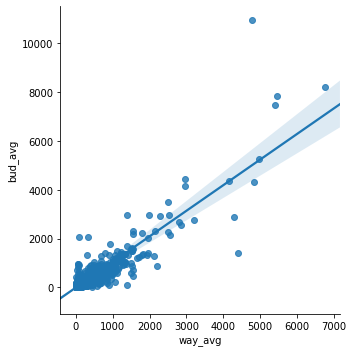

In [17]:
way_avg = np.average(exp_subset.iloc[:,1:4], axis=1)
bud_avg = np.average(exp_subset.iloc[:,4:], axis=1)
gene_avg = pd.DataFrame({'way_avg':way_avg, 'bud_avg':bud_avg})
                      
sns.lmplot(data = gene_avg , x = 'way_avg', y = 'bud_avg');

Run the "differential gene expression analysis":

In [18]:
exp_dea = dea(exp_subset)
exp_dea

id      way_1      way_2      way_3      bud_2      bud_3  \
1662   ENSG00000096384  1680.5205  1724.4549  1762.3271  1224.4538  1238.8875   
4811   ENSG00000130707    92.7289    95.2921    94.3688    54.3534    49.4215   
4275   ENSG00000124440    24.6562    25.9257    22.9764   276.4834   232.2914   
7151   ENSG00000152642    44.8389    35.2146    45.7288   108.8589   104.9683   
10834  ENSG00000185813     7.4216     9.6586     8.2410    28.7552    27.9566   
...                ...        ...        ...        ...        ...        ...   
9652   ENSG00000173457    37.9121    39.0504    32.4267    25.7884    35.9143   
10372  ENSG00000181523    25.2129    29.4380    22.1254    24.9136    22.6690   
653    ENSG00000060558     9.8130     5.0835     6.6734     6.6183     5.2353   
1629   ENSG00000095059    48.9208    50.2340    60.3297    52.4896    48.4791   
3534   ENSG00000116096    21.2547    13.6330    14.7353    15.5947    15.2872   

           bud_1  t_statistic   p_value    log2fc   q_value  
1662   1236.6814   -20.328395  0.000035 -0.481877  0.067541  
4811     55.9159   -19.516145  0.000041 -0.822407  0.067541  
4275    258.6983    17.977735  0.000056  3.383156  0.067541  
7151    102.6550    16.631593  0.000077  1.331195  0.067541  
10834    31.6520    16.177972  0.000085  1.803110  0.067541  
...          ...          ...       ...       ...       ...  
9652     47.7112     0.001237  0.999072  0.000326  0.531916  
10372    29.2022     0.000992  0.999256  0.000160  0.531972  
653       9.7211     0.000833  0.999375  0.000321  0.531995  
1629     58.5211     0.000381  0.999714  0.000048  0.532134  
3534     18.7423     0.000153  0.999886  0.000035  0.532184  

[12918 rows x 11 columns]

In [19]:
print(exp_dea['q_value'].describe(), "\n")
print(exp_dea['p_value'].describe() )

count    12918.000000
mean         0.288198
std          0.129168
min          0.067541
25%          0.179709
50%          0.268216
75%          0.397690
max          0.532184
Name: q_value, dtype: float64 

count    12918.000000
mean         0.340425
std          0.293172
min          0.000035
25%          0.084443
50%          0.252006
75%          0.560502
max          0.999886
Name: p_value, dtype: float64


My lowest q-value however is quite high (>0.05).

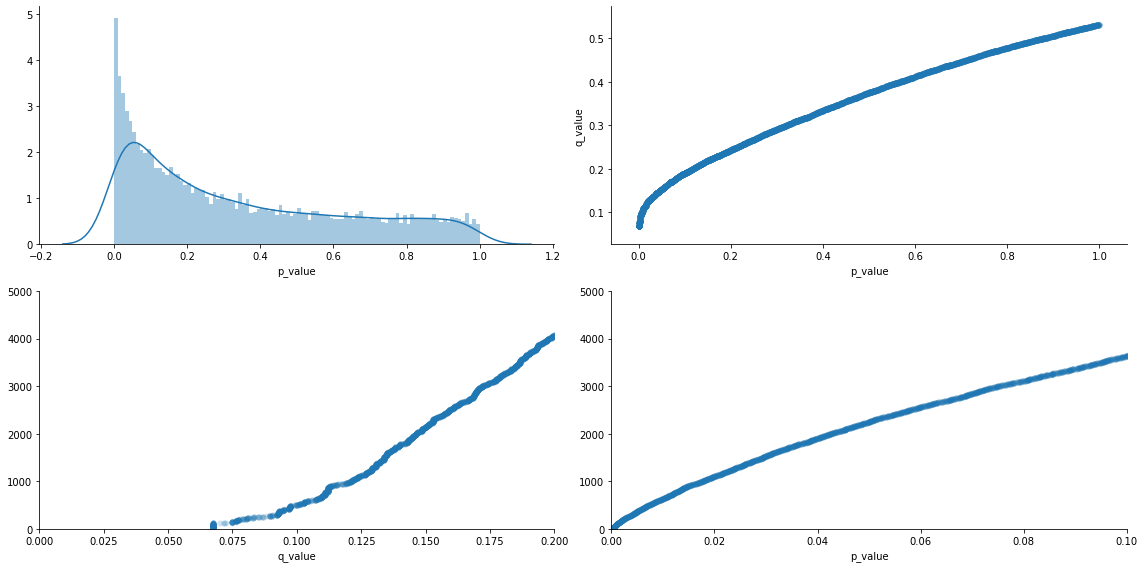

In [20]:
# Some QC plots
f, axes = plt.subplots(2, 2, figsize=(16, 8))

sns.distplot(exp_dea['p_value'], bins = 100, kde = True, ax = axes[0,0])
sns.scatterplot(data = exp_dea, x = "p_value", y = "q_value", linewidth = 0, alpha = .1, ax = axes[0,1])
sns.scatterplot(data = exp_dea, x = "q_value", y = range(len(exp_dea["q_value"])), linewidth = 0, alpha = .1, ax = axes[1,0])
axes[1,0].set_xlim(0, 0.2)
axes[1,0].set_ylim(0, 5e3)
sns.scatterplot(data = exp_dea, x = "p_value", y = range(len(exp_dea["p_value"])), linewidth = 0, alpha = .1, ax = axes[1,1])
axes[1,1].set_xlim(0, 0.1)
axes[1,1].set_ylim(0, 5e3)

sns.despine()
plt.tight_layout();

In [21]:
exp_dea["-log10_pval"] = -np.log10(exp_dea["p_value"])
exp_dea["abs_log2fc"] = np.abs(exp_dea['log2fc'])
exp_dea["cutoff_01"] = (exp_dea['abs_log2fc'] >= np.log2(1.5)) & (exp_dea['p_value'] < 0.01)
exp_dea["cutoff_001"] = (exp_dea['abs_log2fc'] >= 2) & (exp_dea['p_value'] < 0.001)

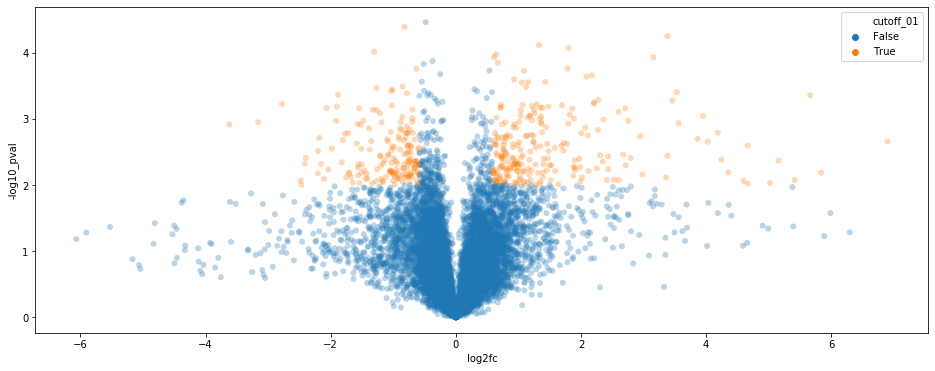

In [22]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data = exp_dea, x = "log2fc", y = "-log10_pval", 
                linewidth = 0, alpha = .3, hue = "cutoff_01");

## Pathways from differentially expressed genes
  
In order to create a network of pathways, I first need to identify which pathways that my differentially expressed genes (DEGs) belong to.  

The steps that I need to take here can be broken down to:  
1. Identify DEGs satisfying specified cut-offs (p-value and/or log-FC)  
2. Identify pathways to which each DEG is part of  
3. Format the information in a way which can be converted into a adjacency matrix/list  
  

### Identify DEGs

In [24]:
p_cutoff = 0.01
fc_cutoff = np.log2(1.5)

degs_df = exp_dea.loc[(exp_dea['p_value'] < p_cutoff) & (exp_dea['abs_log2fc'] >= fc_cutoff),]

degs_df.describe()

way_1       way_2       way_3        bud_2        bud_3  \
count   406.000000  406.000000  406.000000   406.000000   406.000000   
mean     59.576803   58.195367   59.699064    94.000176    85.796286   
std      98.646103   93.969338  105.284870   218.984039   170.494279   
min       0.329800    0.415900    0.313500     0.532500     0.366500   
25%       9.380100    9.681700    8.509800     9.936900     9.855500   
50%      27.367200   25.810200   26.335500    33.566750    34.396100   
75%      69.953825   70.902950   69.768825    92.779250    88.031975   
max    1014.431000  812.940800  975.532300  2864.983000  1627.034600   

             bud_1  t_statistic     p_value      log2fc     q_value  \
count   406.000000   406.000000  406.000000  406.000000  406.000000   
mean     88.292151     1.350046    0.004181    0.419385    0.086631   
std     192.891788     7.060949    0.002866    1.606891    0.013352   
min       0.699900   -19.516145    0.000041   -3.619533    0.067541   
25%       9.847500    -5.548827    0.001624   -0.865127    0.074971   
50%      36.220850     4.877901    0.003920    0.717641    0.092126   
75%      96.132150     6.617856    0.006481    1.270766    0.097446   
max    1896.473000    17.977735    0.009935    6.898735    0.108042   

       -log10_pval  abs_log2fc  
count   406.000000  406.000000  
mean      2.547063    1.374560  
std       0.463886    0.929697  
min       2.002810    0.586218  
25%       2.188345    0.776151  
50%       2.406756    1.049050  
75%       2.789353    1.562774  
max       4.390988    6.898735

In [25]:
degs = degs_df["id"]

degs

4811     ENSG00000130707
4275     ENSG00000124440
7151     ENSG00000152642
10834    ENSG00000185813
6516     ENSG00000144810
              ...       
5747     ENSG00000137962
955      ENSG00000071967
3865     ENSG00000119686
3603     ENSG00000116729
11500    ENSG00000197991
Name: id, Length: 406, dtype: object

### Find pathways for DEGs

I found a python module called `mygene`, which is a wrapper to access data from the <a href="https://mygene.info/">MyGene.info</a> services.

In [26]:
import mygene

In [27]:
mg = mygene.MyGeneInfo()

In [28]:
f = "name, symbol, pathway.reactome"  # "all"
degs_mygene = mg.getgenes(degs, fields = f, as_dataframe = False)

querying 1-406...done.


In [29]:
degs_mygene[:2]

[{'query': 'ENSG00000130707',
  '_id': '445',
  '_score': 19.113523,
  'name': 'argininosuccinate synthase 1',
  'pathway': {'reactome': [{'id': 'R-HSA-1430728', 'name': 'Metabolism'},
    {'id': 'R-HSA-70635', 'name': 'Urea cycle'},
    {'id': 'R-HSA-71291',
     'name': 'Metabolism of amino acids and derivatives'}]},
  'symbol': 'ASS1'},
 {'query': 'ENSG00000124440',
  '_id': '64344',
  '_score': 20.330833,
  'name': 'hypoxia inducible factor 3 subunit alpha',
  'pathway': {'reactome': [{'id': 'R-HSA-1234158',
     'name': 'Regulation of gene expression by Hypoxia-inducible Factor'},
    {'id': 'R-HSA-1234174', 'name': 'Cellular response to hypoxia'},
    {'id': 'R-HSA-1234176',
     'name': 'Oxygen-dependent proline hydroxylation of Hypoxia-inducible Factor Alpha'},
    {'id': 'R-HSA-1266738', 'name': 'Developmental Biology'},
    {'id': 'R-HSA-2262752', 'name': 'Cellular responses to stress'},
    {'id': 'R-HSA-392499', 'name': 'Metabolism of proteins'},
    {'id': 'R-HSA-452723',


In [30]:
degs_mygene_df = pd.DataFrame(degs_mygene)
degs_mygene_df[:5]

query    _id     _score  \
0  ENSG00000130707    445  19.113523   
1  ENSG00000124440  64344  20.330833   
2  ENSG00000152642  23171  20.469358   
3  ENSG00000185813   5833  20.074652   
4  ENSG00000144810   1295  21.300198   

                                             name  \
0                    argininosuccinate synthase 1   
1        hypoxia inducible factor 3 subunit alpha   
2       glycerol-3-phosphate dehydrogenase 1 like   
3  phosphate cytidylyltransferase 2, ethanolamine   
4                collagen type VIII alpha 1 chain   

                                             pathway  symbol notfound  
0  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...    ASS1      NaN  
1  {'reactome': [{'id': 'R-HSA-1234158', 'name': ...   HIF3A      NaN  
2  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...   GPD1L      NaN  
3  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...   PCYT2      NaN  
4  {'reactome': [{'id': 'R-HSA-1442490', 'name': ...  COL8A1      NaN

In [31]:
degs_mygene_df.loc[degs_mygene_df.pathway.isnull()== True, ]

query              _id     _score  \
5    ENSG00000137449           132864  20.073168   
6    ENSG00000132142              NaN        NaN   
10   ENSG00000162613             8880  20.506136   
11   ENSG00000181773             2827  21.317270   
12   ENSG00000138162            10579  19.287067   
..               ...              ...        ...   
393  ENSG00000115295            79745  19.975172   
398  ENSG00000153066            51061  19.964859   
399  ENSG00000116299            57535  21.310799   
403  ENSG00000119686            55640  20.937801   
405  ENSG00000197991  ENSG00000197991  21.310799   

                                                  name pathway      symbol  \
5    cytoplasmic polyadenylation element binding pr...     NaN       CPEB2   
6                                                  NaN     NaN         NaN   
10              far upstream element binding protein 1     NaN       FUBP1   
11                        G protein-coupled receptor 3     NaN        GPR3   
12   transforming acidic coiled-coil containing pro...     NaN       TACC2   
..                                                 ...     ...         ...   
393  CAP-Gly domain containing linker protein famil...     NaN       CLIP4   
398                   thioredoxin domain containing 11     NaN     TXNDC11   
399                                           KIAA1324     NaN    KIAA1324   
403                           FLVCR heme transporter 2     NaN      FLVCR2   
405                                                NaN     NaN  AL592490.1   

    notfound  
5        NaN  
6       True  
10       NaN  
11       NaN  
12       NaN  
..       ...  
393      NaN  
398      NaN  
399      NaN  
403      NaN  
405      NaN  

[174 rows x 7 columns]

In [33]:
# Filter: 
#  - 1: Remove genes that were not found in mygene
genes_rm_1 = degs_mygene_df.loc[(degs_mygene_df.notfound == True), "query"]

print(genes_rm_1, '\n')

6      ENSG00000132142
86     ENSG00000110347
134    ENSG00000182851
216    ENSG00000155130
223    ENSG00000129270
256    ENSG00000261088
279    ENSG00000234635
Name: query, dtype: object 



In [35]:
# Filter: 
#  - 2: Remove genes with no annotated pathways
genes_rm_2 = degs_mygene_df.loc[(degs_mygene_df.pathway.isnull()== True), "query"]

print(genes_rm_2, '\n')

5      ENSG00000137449
6      ENSG00000132142
10     ENSG00000162613
11     ENSG00000181773
12     ENSG00000138162
            ...       
393    ENSG00000115295
398    ENSG00000153066
399    ENSG00000116299
403    ENSG00000119686
405    ENSG00000197991
Name: query, Length: 174, dtype: object 



In [36]:
genes_rm = list(genes_rm_1.index)
genes_rm.extend(list(genes_rm_2.index))

print("Genes without pathways:", len(genes_rm))

Genes without pathways: 181


In [37]:
degs_mygene_df_filt = degs_mygene_df.drop(genes_rm)
degs_mygene_df_filt.shape

(232, 7)

In [38]:
degs_mygene_df_filt = degs_mygene_df_filt.reset_index()

*Out of the 399 filtered DEGs, 232 of them had pathways assigned to them*

Next, I'll have to create a list of all unique reactome pathway IDs that I can use as a backbone for the network. Then, I'll populate an adjacency matrix by looking at each gene and connecting all the pathways that the gene belongs to. I'll also create a separate dictionary containg all pathway ids as keys and the number of genes annotated to that pathway as values.

In [40]:
pw_list = list(degs_mygene_df_filt["pathway"])
pw_ids = list()

for i in range(0,len(pw_list)):
    if type(pw_list[i]) == dict:  # do not consider genes which have no pathways assigned to it (should've been filtered)
        if type(pw_list[i]['reactome']) == list:  # append when a gene has multiple pws assigned
            ids = [d['id'] for d in pw_list[i]['reactome']]
            pw_ids.append(ids)
        elif type(pw_list[i]['reactome']) == dict:  # append when a gene has a single pw assigned
            ids = pw_list[i]['reactome']['id']
            pw_ids.append(ids)
        # print(i, ids[0])

In [41]:
pw_ids_flat = [val for sublist in pw_ids for val in sublist]
pw_ids_flat_unique = list(set(pw_ids_flat))

print("Total number of pathway IDs:", len(pw_ids_flat))
print("Number of unique pathway IDs:", len(pw_ids_flat_unique))

Total number of pathway IDs: 2587
Number of unique pathway IDs: 856


In [44]:
pw_ids[:3]

[['R-HSA-1430728', 'R-HSA-70635', 'R-HSA-71291'],
 ['R-HSA-1234158',
  'R-HSA-1234174',
  'R-HSA-1234176',
  'R-HSA-1266738',
  'R-HSA-2262752',
  'R-HSA-392499',
  'R-HSA-452723',
  'R-HSA-597592',
  'R-HSA-8951664',
  'R-HSA-8953897'],
 ['R-HSA-1430728',
  'R-HSA-1483166',
  'R-HSA-1483206',
  'R-HSA-1483257',
  'R-HSA-556833']]

### Create adjacency matrix

Create a weighted adjacency matrix. For every time a pathway shares a gene, it will increase it's weight by one. Thus, pathways which are commonly annotated together will show a high connectivity.

For every pathway, I'll also create a dictionary containing the number of occurances of that pathway (i.e. number of genes assigned to that pw).

In [45]:
pwd_list = pw_ids_flat_unique
n = len(pwd_list)
adj_matrix = np.zeros((n, n))
pw_dict = dict()

for pw in pwd_list:
    pw_count = 0
    pw_index = pwd_list.index(pw)
    
    all_pws = [d for d in pw_ids if pw in d]
    pw_dict[pw] = len(all_pws)
    
    for gene_pws in all_pws:
        for gene_pw in gene_pws:
            gene_pw_index = pwd_list.index(gene_pw)            
            
            if pw_index != gene_pw_index:
                adj_matrix[pw_index, gene_pw_index] += 1
                adj_matrix[gene_pw_index, pw_index] += 1
            else:
                pw_count += 1

Look at adjacency matrix and pathway weights

In [46]:
print(adj_matrix.shape)
adj_matrix

(856, 856)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 4., 0.]])

In [47]:
# Show first 10 items in the pw_dict dictionary
import itertools

print(len(pw_dict))
dict(itertools.islice(pw_dict.items(), 10))

#pw_dict[pw_ids_flat[1]]

856


{'R': 1,
 'R-HSA-157118': 4,
 'R-HSA-2559580': 1,
 'R-HSA-5675221': 2,
 'R-HSA-110331': 1,
 'R-HSA-73728': 1,
 'R-HSA-427359': 1,
 'R-HSA-210991': 1,
 'R-HSA-77346': 1,
 'R-HSA-70326': 1}

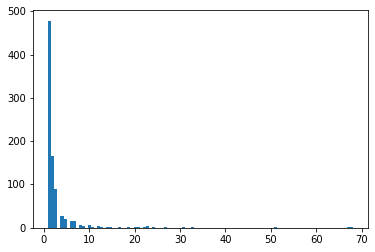

In [48]:
plt.hist(pw_dict.values(), bins=100);

In [49]:
len(adj_matrix.sum(axis=1))

856

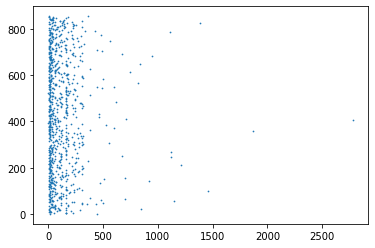

In [50]:
# plt.hist(adj_matrix[0], bins = 100);

a = adj_matrix.sum(axis=1)  # [adj_matrix.sum(axis=1)!=0]  # if remove pathways with 0 connections
plt.scatter(a, range(0, len(a)), s = .5);

It seems most pathways doesn't have a lot of connections, while a few are very well connected with other pathways.

----
Make pathway column in `degs_mygene_df_filt` searchable by setting it as a string (instead of dict).

In [51]:
degs_mygene_df_filt['pathway_str'] = degs_mygene_df_filt['pathway'].astype(str)

In [52]:
# Search for genes containing specified pathway
pw_search = "R-HSA-71291"
degs_mygene_df_filt[degs_mygene_df_filt['pathway_str'].str.contains(pw_search)]

index            query    _id     _score  \
0        0  ENSG00000130707    445  19.113523   
50      85  ENSG00000075239     38  20.146020   
66     111  ENSG00000116761   1491  19.685114   
82     138  ENSG00000176894   5827  20.030642   
108    181  ENSG00000059573   5832  19.372662   
112    189  ENSG00000182551  55256  20.509266   
114    191  ENSG00000135821   2752  20.590890   
127    212  ENSG00000119711   4329  19.613226   
183    320  ENSG00000088826  54498  19.594473   
222    389  ENSG00000197406   1735  20.569008   

                                           name  \
0                  argininosuccinate synthase 1   
50               acetyl-CoA acetyltransferase 1   
66                    cystathionine gamma-lyase   
82               peroxisomal membrane protein 2   
108  aldehyde dehydrogenase 18 family member A1   
112                  acireductone dioxygenase 1   
114                    glutamate-ammonia ligase   
127   aldehyde dehydrogenase 6 family member A1   
183                            spermine oxidase   
222                  iodothyronine deiodinase 3   

                                               pathway    symbol notfound  \
0    {'reactome': [{'id': 'R-HSA-1430728', 'name': ...      ASS1      NaN   
50   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...     ACAT1      NaN   
66   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...       CTH      NaN   
82   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...     PXMP2      NaN   
108  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  ALDH18A1      NaN   
112  {'reactome': [{'id': 'R-HSA-1237112', 'name': ...      ADI1      NaN   
114  {'reactome': [{'id': 'R-HSA-112313', 'name': '...      GLUL      NaN   
127  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...   ALDH6A1      NaN   
183  {'reactome': [{'id': 'R-HSA-140179', 'name': '...      SMOX      NaN   
222  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...      DIO3      NaN   

                                           pathway_str  
0    {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
50   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
66   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
82   {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
108  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
112  {'reactome': [{'id': 'R-HSA-1237112', 'name': ...  
114  {'reactome': [{'id': 'R-HSA-112313', 'name': '...  
127  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...  
183  {'reactome': [{'id': 'R-HSA-140179', 'name': '...  
222  {'reactome': [{'id': 'R-HSA-1430728', 'name': ...

---

### Save objects before proceeding with next steps

In [53]:
fname = "degs_mygene_df_filt.csv"
degs_mygene_df_filt.to_csv(os.path.join(dir_res, fname), index=False)

In [54]:
np.save(os.path.join(dir_res, "adj_matrix"), adj_matrix)

## Build a network

In [55]:
import networkx as nx

In [56]:
G = nx.from_numpy_matrix(adj_matrix)

In [57]:
G.size()

17661

In [58]:
A = nx.adjacency_matrix(G)

In [59]:
A

<856x856 sparse matrix of type '<class 'numpy.float64'>'
	with 35322 stored elements in Compressed Sparse Row format>

In [62]:
# Create label dict
g_labels = dict(zip(list(range(0, len(pw_dict))), list(pw_dict.keys())))

In [63]:
adj_matrix.shape

(856, 856)

Look at the network:

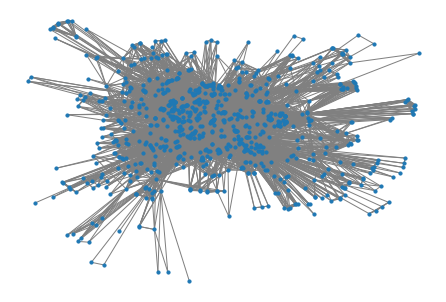

In [64]:
nx.draw(G, node_size = 10, edge_color = 'gray');

The network currently looks like a big ball of nodes, which I think makes sense for this kind of data.

Draw network where edge widths corresponds to their weight, and the node sizes corresponds to the number of genes sharing that pathway:

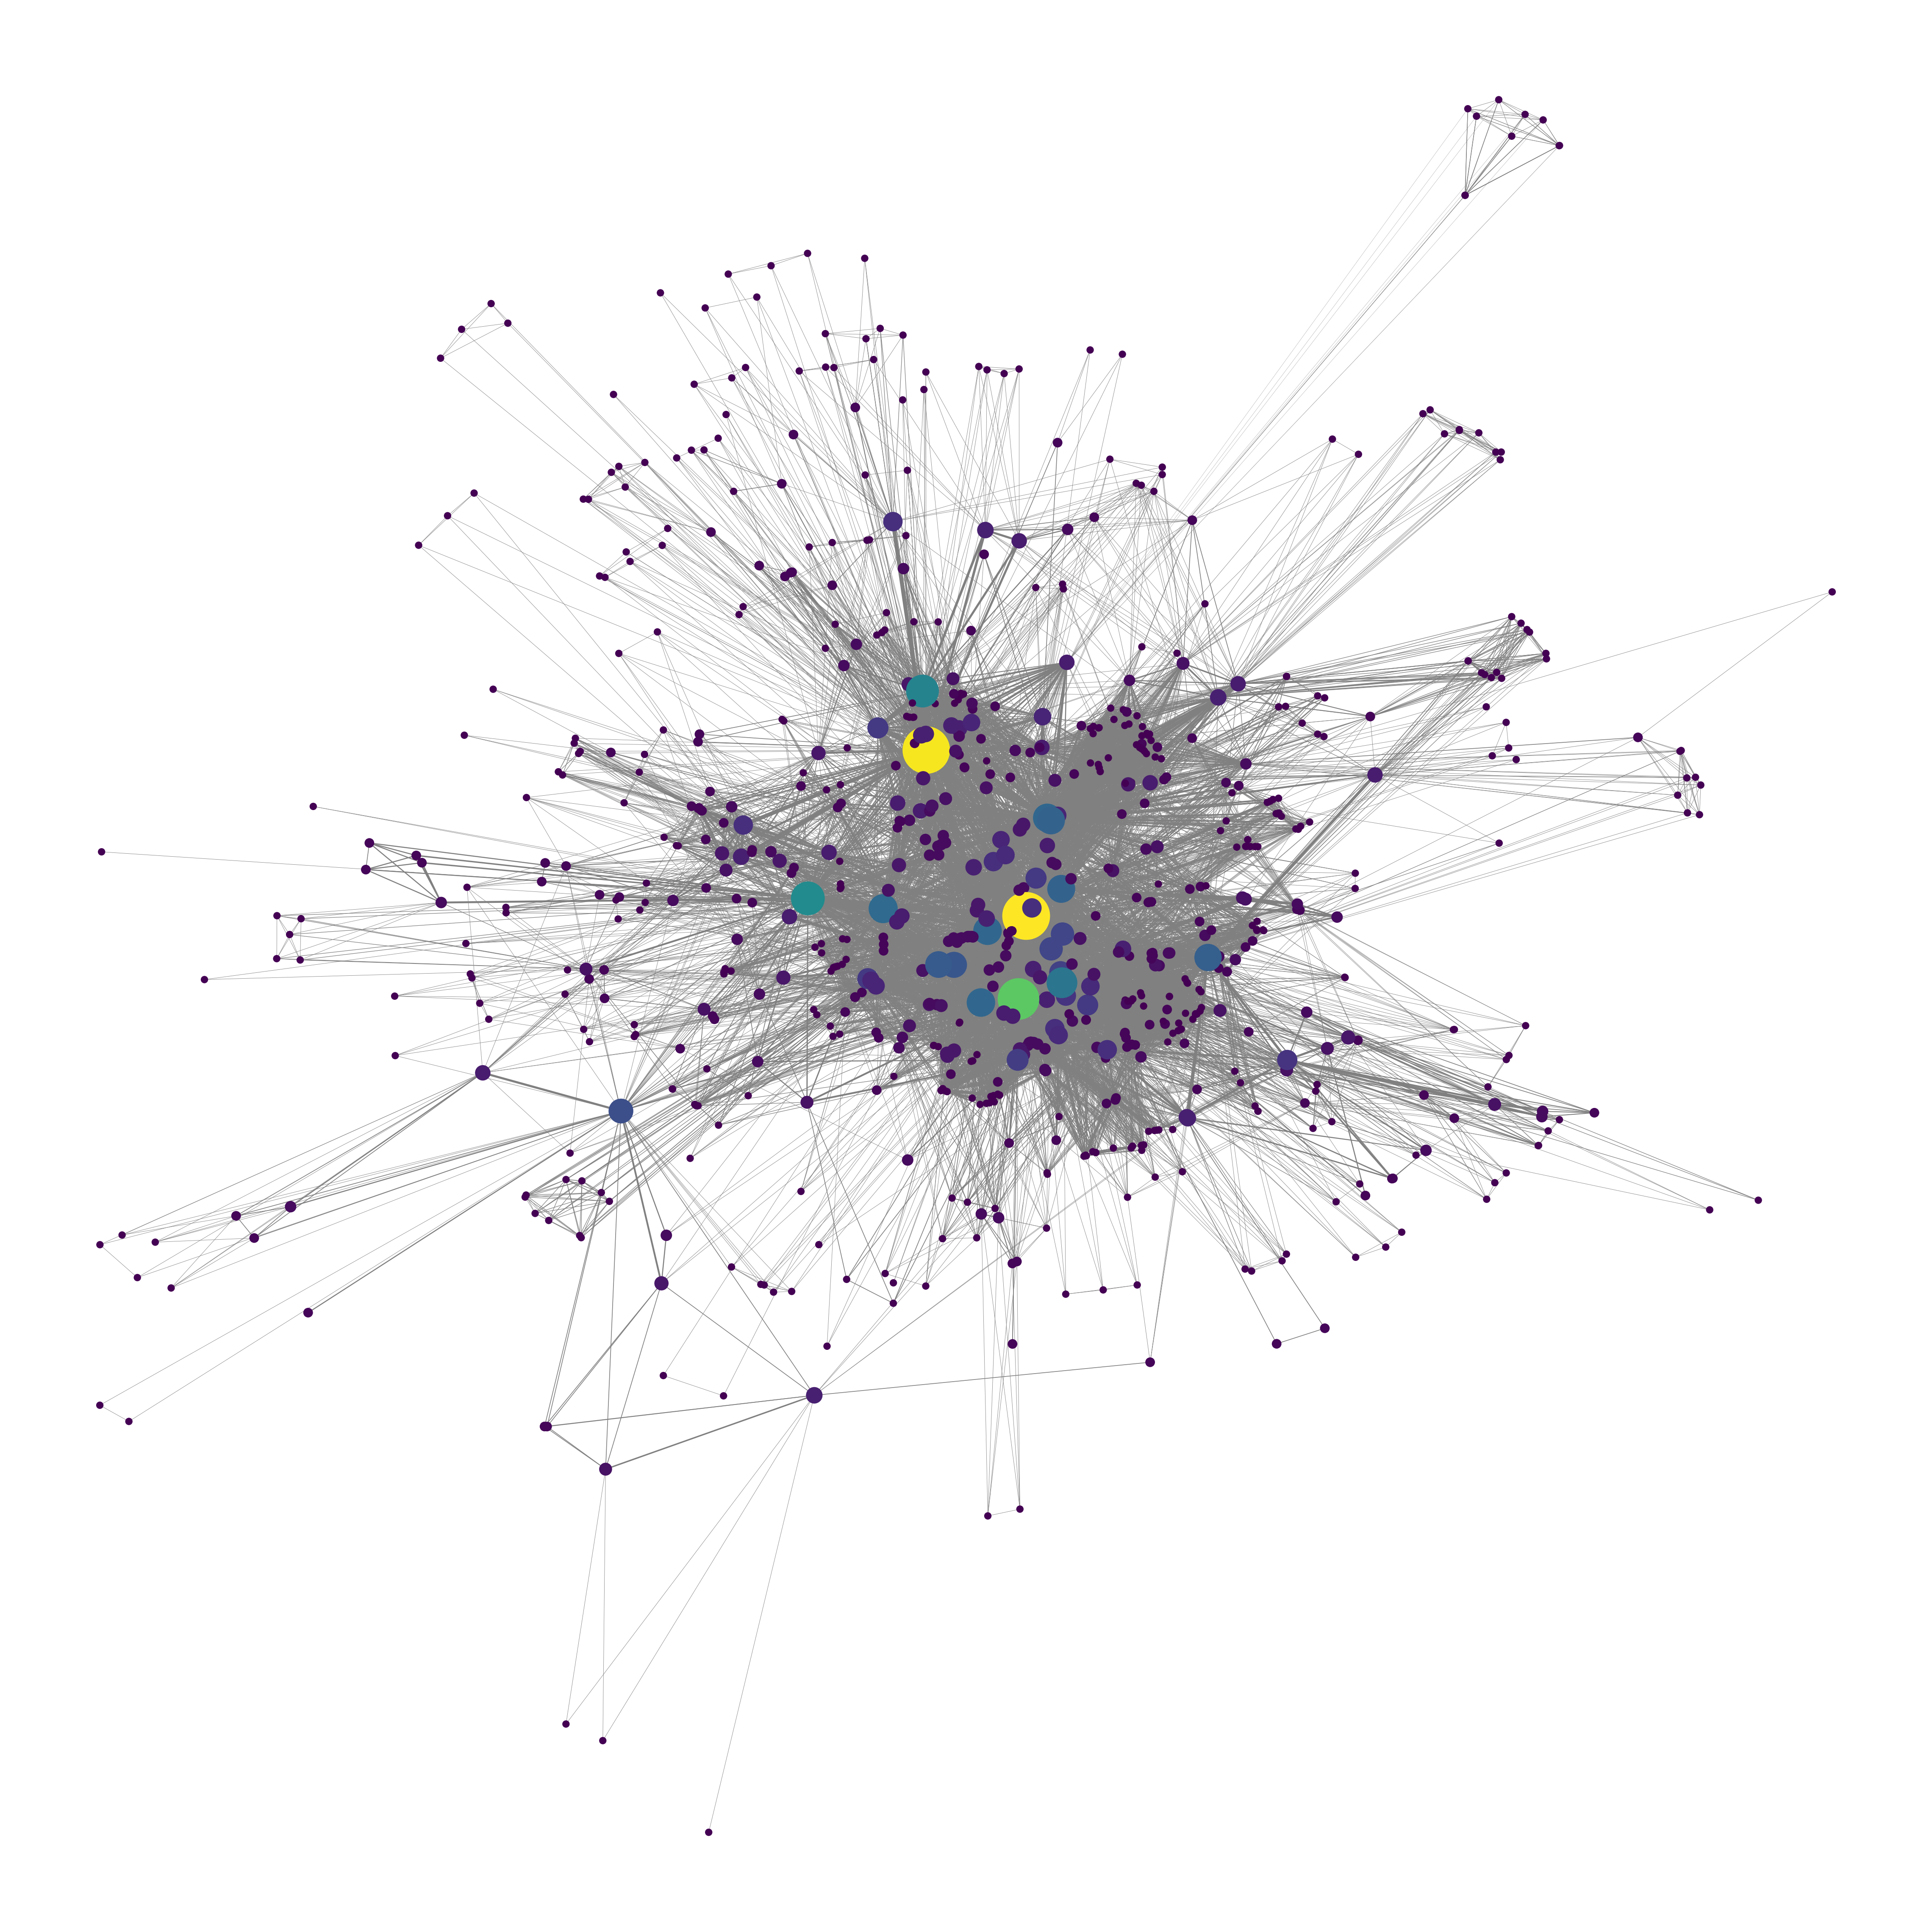

In [65]:
edges = G.edges()
#colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight']/10 for u,v in edges]
n_size = [v * 10 for v in pw_dict.values()]

plt.figure(figsize=(15,15),dpi=300)

nx.draw(G, 
        edges = edges, 
        width = weights, 
        edge_color = 'gray',
        # labels=g_labels, 
        # with_labels = True, font_size=6,
        # nodelist=g_labels, 
        node_size = n_size,
        node_color = n_size
        #cmap = plt.cm.YlOrRd
       )

plt.tick_params(
    axis = 'both',       # changes apply to both axes
    which = 'both',      # both major and minor ticks are affected
    bottom = 'off',      # ticks along the bottom edge are off
    top = 'off',         # ticks along the top edge are off
    labelbottom = 'off', # labels along the bottom edge are off
    left = 'off',
    labelleft = 'off')

plt.show;

This looks a lot nicer! Now I just need to be able to detect what nodes corresponds to what pathway in a easy and interactive way. It would also be great to include some form of pathway classification that can serve as color-coding for the nodes. That would make it easier to for instance spot a cluster of inflammation-related pathways.

To make the graph interactive, my first-hand choice would be to see if the Plotly module could be of use here. I found a tutorial for it here: https://plot.ly/python/network-graphs/
However, an easier way to do it might be using 'mpld3' (https://mpld3.github.io/)  


In [758]:
import mpld3

In [760]:
pos = nx.spring_layout(G)

TypeError: Object of type ndarray is not JSON serializable

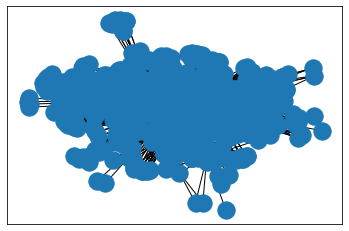

In [778]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#FFFFFF'))
scatter = nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)

labels = G.nodes()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#mpld3.display()
#mpld3.show()

Disclaimer: This is not a true pathway enrichment that I've done here, since ideally you'd also want to take the pathway size (i.e. number of genes annotated within a pathway from the database) into consideration. Some pathways involve hundreds of genes, and seeing many genes from our DEG list within such pathways wouldn't be very surprising in that case, while if a pathway only has ten genes associated with it and nine of them can be found within our DEG list that would be a finding with a lot more significance. In many pathway enrichment tools, they report the percentages of pathway genes found from your given gene list as well as a statistical test, such as Fisher's exact test, where multiple-test correction is also applied.